In [ ]:
'''
X = tokenized_data["is_profanity"]
y = tokenized_data["comment_body"]
print(type(X))
label_encoder = LabelEncoder() 
y = label_encoder.fit_transform(y)
print(y)
'''

In [112]:
%tensorflow_version 1.x
import sqlite3
# Keras~=2.2.5
import pandas as pd
import os
import keras
import numpy as np
import keras.backend.tensorflow_backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

#con = sqlite3.connect("/content/sorted_tokenized_comments.db")
#tokenized_data = pd.read_sql("SELECT * FROM tok_comments", con)
df = pd.read_csv("sorted_tokenized_comments.csv", delimiter= ",", encoding="utf8")
df.comment_body= df.comment_body.astype(str)
df.head()



,Unnamed: 0,comment_id,date,title,body,comment_body,is_profanity
0,0,0,2021-04-08 00:04:07,Vladimir Putin Faces Mass Russia Protest as Al...,NaN,he s literally in a prison run partially by ...,yes
1,1,1,2021-04-08 00:04:07,Vladimir Putin Faces Mass Russia Protest as Al...,NaN,i m sure some hard up prisoner will make that ...,yes
2,2,2,2021-04-08 00:04:07,Vladimir Putin Faces Mass Russia Protest as Al...,NaN,putin s siberian nightmare surprised he did...,yes
3,3,3,2021-04-08 00:04:07,Vladimir Putin Faces Mass Russia Protest as Al...,NaN,i wish you could reach out and stop things lik...,no
4,4,4,2021-04-08 00:04:07,Vladimir Putin Faces Mass Russia Protest as Al...,NaN,russia a man is willing to die for what h...,yes


In [113]:
df.drop(["Unnamed: 0", "comment_id", "date", "title", "body"], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49533 entries, 0 to 49532
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_body  49533 non-null  object
 1   is_profanity  49533 non-null  object
dtypes: object(2)
memory usage: 774.1+ KB


In [114]:
df.head()

,comment_body,is_profanity
0,he s literally in a prison run partially by ...,yes
1,i m sure some hard up prisoner will make that ...,yes
2,putin s siberian nightmare surprised he did...,yes
3,i wish you could reach out and stop things lik...,no
4,russia a man is willing to die for what h...,yes


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'count of profane and none profane comments')

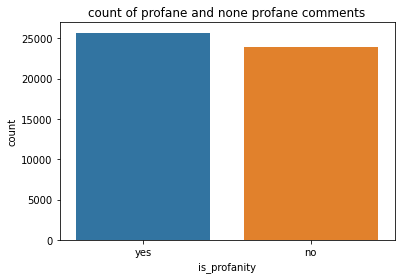

In [115]:
sns.countplot(df.is_profanity)
plt.xlabel("is_profanity")
plt.title("count of profane and none profane comments")

In [116]:
X = df.comment_body.values
y = df.is_profanity.values
print(type(X))

<class 'numpy.ndarray'>


In [117]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(y)


[1 1 1 ... 0 0 0]


In [118]:
print(y.shape)
print(X.shape)

(49533,)
(49533,)


In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [125]:
max_words = 40000
max_len = 1500

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)

In [126]:
sequences = tok.texts_to_sequences(X_train)

In [127]:
count = 0 
for i in sequences:
  print(len(i))
  count += 1 
  if count > 10:
    break

30
19
4
27
34
4
1
16
12
22
18


In [128]:
sequence_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
sequence_matrix[0]

array([   0,    0,    0, ..., 6160,   24,    2], dtype=int32)

In [129]:
count = 0 
for i in sequence_matrix:
  print(i)
  count += 1 
  if count > 3: 
    break 

[   0    0    0 ... 6160   24    2]
[   0    0    0 ...   18 2453  360]
[   0    0    0 ... 4105  893 1597]
[   0    0    0 ...  136   23 9338]


In [130]:
!mkdir -p saved_model
model.save('saved_model/profanity_LSTM') 

In [131]:
with K.tf_ops.device('device:GPU:0'):
    model = Sequential()
    #max_words to 50 dim. so I will be putting 40000 words in to 50 dim. length of the word would be max_len
    model.add(Embedding(max_words, 50, input_length=max_len))
    model.add(LSTM(64))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model_dir = 'saved_model/'
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    model_path = model_dir + "profanity_LSTM"
    
    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=7)

In [132]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1500, 50)          2000000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_15 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total params: 2,046,337
Trainable params: 2,046,337
Non-trainable params: 0
_________________________________________________________________


In [133]:
hist = model.fit(sequence_matrix, y_train, batch_size=128, epochs=10, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Train on 31700 samples, validate on 7926 samples
Epoch 1/10
31700/31700 [==============================] - 490s 15ms/step - loss: 0.4118 - accuracy: 0.8062 - val_loss: 0.2549 - val_accuracy: 0.8943

Epoch 00001: val_loss improved from inf to 0.25488, saving model to saved_modelprofanity_LSTM
Epoch 2/10
31700/31700 [==============================] - 493s 16ms/step - loss: 0.1529 - accuracy: 0.9443 - val_loss: 0.2407 - val_accuracy: 0.9087

Epoch 00002: val_loss improved from 0.25488 to 0.24072, saving model to saved_modelprofanity_LSTM
Epoch 3/10
31700/31700 [==============================] - 490s 15ms/step - loss: 0.0765 - accuracy: 0.9755 - val_loss: 0.2587 - val_accuracy: 0.9131

Epoch 00003: val_loss did not improve from 0.24072
Epoch 4/10
31700/31700 [==============================] - 489s 15ms/step - loss: 0.0504 - accuracy: 0.9843 - val_loss: 0.2869 - val_accuracy: 0.9148

Epoch 00004: val_loss did not improve from 0.24072
Epoch 5/10
31700/31700 [==============================] -

In [134]:
sequences_test = tok.texts_to_sequences(X_test)
sequences_matrix_test = sequence.pad_sequences(sequences_test, maxlen=max_len)
print("Accuracy : %.4f" % (model.evaluate(sequences_matrix_test, y_test)[1]))

9907/9907 [==============================] - 56s 6ms/step
Accuracy : 0.9200


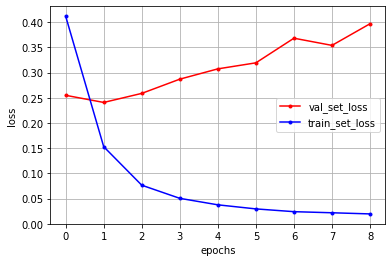

In [136]:
y_vloss = hist.history['val_loss']
y_loss = hist.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

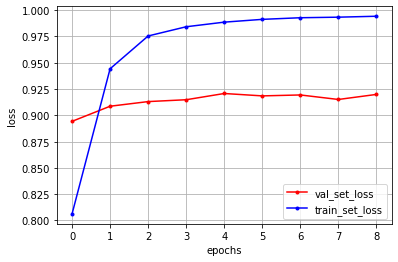

In [140]:
y_vloss = hist.history['val_accuracy']
y_loss = hist.history['accuracy']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()